In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

### Code for the actuall mel-filterbanks energies in python

In [ ]:
# Define parameters
sample_rate = 16000
window_duration = 0.025  # 25 ms
window_stride = 0.015  # 15 ms
FFT_length = 512
mel_bins = 40
fmin = 80
fmax = 2500

win_length = int(window_duration * sample_rate)
hop_length = int(window_stride * sample_rate)

def mel_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=win_length, frame_step=hop_length, window_fn=tf.signal.hann_window, pad_end=False)
    magnitude = tf.abs(spectrogram) #we don't need this since we're taking power=2 anyways | complex numbers .
    power = tf.math.pow(magnitude, 2)

    mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=mel_bins,
        num_spectrogram_bins=power.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=fmin,
        upper_edge_hertz=fmax)

    mel_spectrogram = tf.matmul(power, mel_weights)
    log_mel = tf.math.log(mel_spectrogram + 1e-6)

    # mel_spectrogram = tf.expand_dims(log_mel, axis=-1)  # Now shape = (time, 80, 1)
    return log_mel

### Testing it on a random clip

In [ ]:
import librosa
#load audio.wav
audio, sr = librosa.load('audio.wav', sr=sample_rate)

from IPython.display import Audio
clip = Audio(audio, rate=16_000)
display(clip)

In [ ]:
import librosa
#load audio.wav
audio, sr = librosa.load('audio.wav', sr=sample_rate)

#convert audio to a tensor
audio = tf.convert_to_tensor(audio)
print(audio.shape)
#get mel_spectogram
mel_spec = mel_spectrogram(audio)
print(mel_spec.shape)

(16000,)
(66, 40)


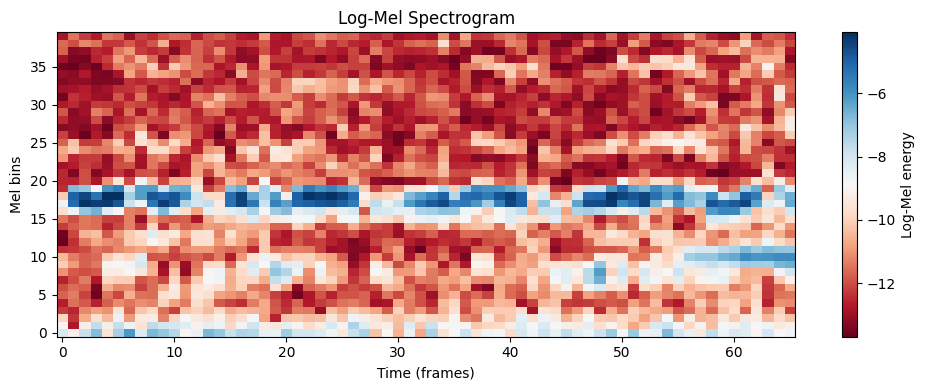

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# mel_spec shape: [frames, mel_bins] — convert to numpy if it's still a tensor
mel_spec_np = mel_spec.numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_np.T, aspect='auto', origin='lower', cmap='RdBu')
plt.colorbar(label='Log-Mel energy')
plt.xlabel('Time (frames)')
plt.ylabel('Mel bins')
plt.title('Log-Mel Spectrogram')
plt.tight_layout()
plt.show()


### Generating and saving the triangular matrix


In [ ]:
mel_weights = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=mel_bins,
        num_spectrogram_bins=257,
        sample_rate=sample_rate,
        lower_edge_hertz=fmin,
        upper_edge_hertz=fmax)
filterbanks = mel_weights.numpy().T
print(filterbanks.shape)
print(filterbanks.dtype)
#save to bin
# filterbanks.astype(np.float32).tofile("filterbank.bin")

#or save using the next cell, with a .h file of floats instead of bins
filterbanks[0]

(40, 257)
float32


array([0.        , 0.        , 0.        , 0.5075463 , 0.37089175,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
with open("filterbanks.h", "w") as f:
    f.write("#pragma once\n\n")
    f.write(f"#define num_mel_bins {filterbanks.shape[0]}\n")
    f.write(f"#define fft_length {filterbanks.shape[1]}\n\n")
    f.write("static const float filterbanks[NUM_MEL_BINS][FFT_BINS] = {\n")

    for row in filterbanks:
        row_str = ", ".join(f"{x:.8f}" for x in row)
        f.write(f"    {{{row_str}}},\n")

    f.write("};\n")


In [ ]:
#export first slice of audio
audio, sr = librosa.load('audio.wav', sr=sample_rate)
slice1 = audio[:win_length]

# Save as float32 binary
# then use this as a .h file for your arduino
# and put it on a static buffer for testing and comparing
# this is only done once for testnig and not on the main method...
slice1.astype(np.float32).tofile("slice1.bin")

In [ ]:
print(slice1.shape)
print(slice1.dtype)

(400,)
float32


In [ ]:
import sys
print(sys.byteorder)  # arduino usess little-endian too, so if this was big then copying the bytes won't work of course

little


### Comparing the python/C++ outputs

In [ ]:
compare = mel_spectrogram(audio)
#print min and max cleanly
print(f"Full spectogram information, min: {compare.numpy().min():.7f}, max: {compare.numpy().max():.7f}\n\nPrinting 1st slice:")
compare.numpy()[0]

Full spectogram information, min: -13.6865740, max: -4.0819020

Printing 1st slice:


array([ -8.161305 ,  -8.987899 ,  -9.904236 , -12.247403 , -12.665002 ,
       -11.712872 , -11.9798355, -12.585088 , -11.04146  , -10.073989 ,
       -10.446439 , -12.401709 , -13.607453 , -13.50238  , -12.188251 ,
       -11.459212 ,  -9.714063 ,  -8.652343 , -10.099911 , -12.42201  ,
       -12.528473 , -12.498552 , -12.8803215, -11.016556 , -10.727708 ,
       -11.702394 , -12.180368 , -13.247804 , -12.473625 , -11.882607 ,
       -12.739781 , -13.4821205, -12.973598 , -13.297318 , -13.097194 ,
       -13.505122 , -12.928269 , -11.731985 , -11.592328 , -12.806074 ],
      dtype=float32)

In [ ]:
#output from the Arduino nano BLE 33 sense serial
arr = np.array([-8.16, -8.98, -9.91, -12.23, -12.67, -11.72, -11.98, -12.58, -11.03, -10.08,
 -10.45, -12.40, -13.61, -13.50, -12.19, -11.46, -9.72, -8.67, -10.12, -12.45,
 -12.53, -12.50, -12.88, -11.02, -10.74, -11.72, -12.19, -13.25, -12.47, -11.88,
 -12.74, -13.48, -12.98, -13.30, -13.10, -13.51, -12.93, -11.73, -11.60, -12.82]) # took 3.5 ms

#output from the portenta H7 board:
[-8.157111, -8.979344, -9.909517, -12.225720, -12.669367, -11.719714, -11.978657, -12.584855, -11.032768,
 -10.075119, -10.445874, -12.395961, -13.610758, -13.497763, -12.187438, -11.457288, -9.722334, -8.669933,
 -10.117890, -12.454246, -12.528508, -12.497205, -12.878761, -11.018210, -10.739545, -11.721861, -12.188902,
 -13.249899, -12.470394, -11.882287, -12.744804, -13.482313, -12.977035, -13.301853, -13.103784, -13.508370,
 -12.927471, -11.733249, -11.604427, -12.816597] #took 0.5 ms

arr.shape

(40,)

In [ ]:
np.mean(np.abs(arr-compare))

np.float32(0.0062687634)

In [ ]:
np.abs(arr - compare).max()

np.float32(0.027989388)